In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

## План

 + [1. EDA](#EDA)
 + [2. Обработка выбросов и заполнение пропусков](#Processing)
 + [3. Построение новых признаков](#NewFeature)
 + [4. Построение модели](#Model)
 + [5. Прогнозирование на тестовом датасете](#Finish)

#### Пути к файлам

In [4]:
TRAIN_DATASET_PATH = './input/train.csv'
TEST_DATASET_PATH = './input/test.csv'
SUBMIT_FILE_PATH = './input/sample_submission.csv'

OUTPUT_FILE = './output/result.csv'

## Загрузка данных

### Описание датасета

- **Id** - идентификационный номер квартиры
- **DistrictId** - идентификационный номер района
- **Rooms** - количество комнат
- **Square** - площадь
- **LifeSquare** - жилая площадь
- **KitchenSquare** - площадь кухни
- **Floor** - этаж
- **HouseFloor** - количество этажей в доме
- **HouseYear** - год постройки дома
- **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
- **Social_1, Social_2, Social_3** - социальные показатели местности
- **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
- **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
- **Price** - цена квартиры


In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2


Приведение типов

In [6]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

train_df.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### 1. EDA
<a name ="EDA"></a>

#### Целевая переменная

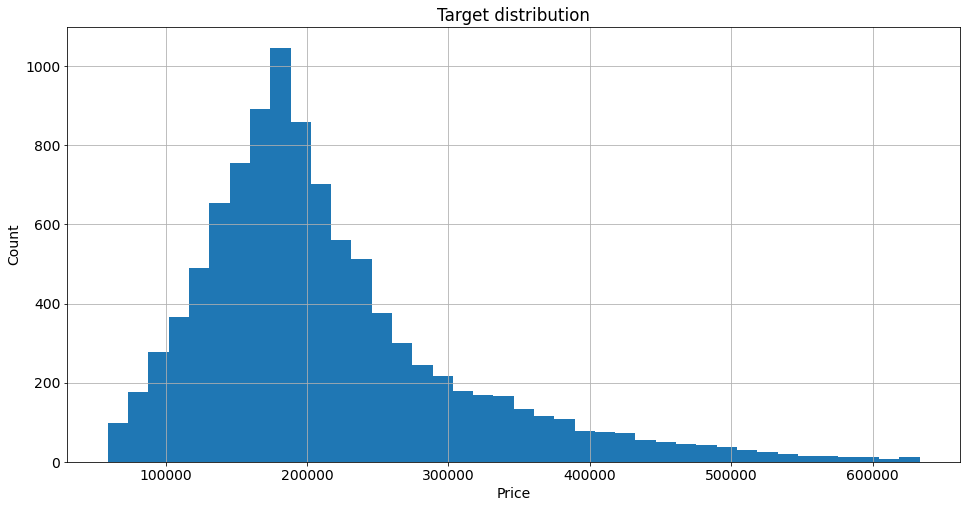

In [7]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=40)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()


#### Количественные переменные

In [8]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Номинативные переменные

In [9]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [10]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
205      1
174      1
117      1
207      1
199      1
Name: DistrictId, Length: 205, dtype: int64

In [11]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [12]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [13]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## 2. Обработка выбросов и заполнение пропусков
<a name ="Processing"></a>
**Rooms**

In [14]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [15]:
train_df['Rooms_outlier'] = 0

train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [16]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**KitchenSquare**

In [17]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [18]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)


(13.0, 0.0)

In [19]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))

train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [20]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

**HouseFloor, Floor**

In [21]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [22]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [23]:
# Этаж больше чем этажность дома
(train_df['Floor'] > train_df['HouseFloor']).sum()


1825

In [24]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1


In [25]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [26]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [27]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [28]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

In [29]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [30]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

**Square**
##### Минимальная площадь квартир по Москве 11.2 кв.м. http://www.thewaveofdecor.ru/2019/11/%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D1%80%D0%B0-11-%D0%BC%D0%B5%D1%82%D1%80%D0%BE%D0%B2-%D0%BC%D0%B8%D1%84-%D0%B8%D0%BB%D0%B8-%D1%80%D0%B5%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C.html/
##### Будем ориентироваться на эти значения как на минимальные при выбросах

In [31]:
train_df.loc[train_df['Square'] < 11.2, 'Square'].count()

12

In [32]:
train_df.loc[train_df['Square'] < 11.2, 'Square'] = 11.2

**LifeSquare**

In [33]:
train_df['LifeSquare'].isna().sum()

2113

In [34]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())

train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

In [35]:
train_df['LifeSquare'].describe()

count    10000.000000
mean        40.734674
std         77.610357
min          0.370619
25%         25.285992
50%         35.527336
75%         48.706162
max       7480.592129
Name: LifeSquare, dtype: float64

In [36]:
# Жилая площадь не может быть больше общей
condition = (~train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna()) \
             & (train_df['LifeSquare'] > train_df['Square'])
train_df.loc[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan
33,847,74,2.0,73.314975,74.131261,3.0,5,6.0,1977,0.075779,...,1437,3,NaN,0,2,B,254005.381863,0,1,0
64,3992,1,3.0,87.200625,87.730225,3.0,21,22.0,1977,0.007122,...,264,0,NaN,0,1,B,300180.365669,0,0,0
77,11771,45,1.0,38.467276,39.624493,3.0,3,9.0,1977,0.195781,...,5212,6,NaN,3,2,B,247440.530601,0,1,0
100,13343,74,2.0,79.937665,82.931595,3.0,8,21.0,1977,0.075779,...,1437,3,NaN,0,2,B,226808.747168,0,0,0
111,13875,20,1.0,28.438794,32.514021,6.0,6,10.0,2014,0.019509,...,7687,11,176.0,5,5,B,199248.114376,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,3.0,1,1.0,2017,0.041125,...,9515,5,NaN,1,10,B,524365.550705,0,1,0
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,...,3889,6,705.0,3,6,B,87556.385617,0,0,0
9979,2201,6,1.0,40.043234,41.984322,3.0,3,17.0,2014,0.243205,...,1564,0,540.0,0,0,B,134888.083598,0,0,0
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,...,264,0,NaN,0,1,B,203908.192698,0,0,0


In [37]:
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare']
train_df['LifeSquare'].describe()

count    10000.000000
mean        39.614766
std         21.269647
min          0.370619
25%         25.207291
50%         35.296055
75%         48.475670
max        638.163193
Name: LifeSquare, dtype: float64

In [38]:
# По нормам жилищного кодекса ст. 105-106, жилая площадь не может быть меньше 6 кв. м
# для маленьких квартир, будем считать что комната совмещена с кухней

train_df.loc[(train_df['LifeSquare'] + train_df['KitchenSquare']) < 6, 'LifeSquare'] = 6 - train_df['KitchenSquare']
train_df['LifeSquare'].describe()

count    10000.000000
mean        39.623672
std         21.254004
min          0.795539
25%         25.207291
50%         35.296055
75%         48.475670
max        638.163193
Name: LifeSquare, dtype: float64

**Healthcare_1**

In [39]:
healthcare_district_med = train_df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
healthcare_district_med

{'0': 2073.5833333333335,
 '1': 228.7719298245614,
 '10': nan,
 '100': 770.0,
 '101': 1427.1134020618556,
 '102': 705.0,
 '103': 2219.0526315789475,
 '104': 1630.909090909091,
 '105': 2861.5,
 '106': 2943.0,
 '107': 700.0,
 '108': 60.44444444444444,
 '109': 421.0731707317073,
 '11': 1298.6166666666666,
 '110': 1322.0,
 '111': 1623.469387755102,
 '112': nan,
 '113': 253.65853658536585,
 '114': 1686.6666666666667,
 '115': 2009.0,
 '116': 2123.6363636363635,
 '117': nan,
 '118': 1711.5384615384614,
 '119': 1322.0,
 '12': nan,
 '120': 3284.846153846154,
 '121': 605.88,
 '122': 1322.0,
 '123': 1039.53125,
 '124': 1812.4545454545455,
 '125': 1687.4,
 '126': 1183.0,
 '127': nan,
 '128': 30.0,
 '129': 1256.923076923077,
 '13': 1406.0,
 '130': 1658.896551724138,
 '131': nan,
 '132': 2059.0,
 '133': 3593.2,
 '134': 2105.277777777778,
 '135': 2301.0,
 '136': 176.0,
 '137': 538.3333333333334,
 '138': 2967.75,
 '139': 1894.0,
 '14': 1869.1176470588234,
 '140': 705.0,
 '141': 4129.0,
 '142': 800.0,


In [40]:
train_df['Healthcare_1'].fillna(train_df.median()['Healthcare_1'], inplace=True)
q_healthcare1 = np.quantile(train_df['Healthcare_1'], q=0.75)

In [41]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['DistrictId'].map(healthcare_district_med)
train_df['Healthcare_1'].clip(upper=q_healthcare1, axis=0, inplace=True)

train_df['Healthcare_1'].describe()

count    10000.000000
mean       791.387900
std        275.145001
min          0.000000
25%        830.000000
50%        900.000000
75%        990.000000
max        990.000000
Name: Healthcare_1, dtype: float64

In [42]:
# Проверяем на пропуски

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  object 
 1   DistrictId          10000 non-null  object 
 2   Rooms               10000 non-null  float64
 3   Square              10000 non-null  float64
 4   LifeSquare          10000 non-null  float64
 5   KitchenSquare       10000 non-null  float64
 6   Floor               10000 non-null  int64  
 7   HouseFloor          10000 non-null  float64
 8   HouseYear           10000 non-null  int64  
 9   Ecology_1           10000 non-null  float64
 10  Ecology_2           10000 non-null  object 
 11  Ecology_3           10000 non-null  object 
 12  Social_1            10000 non-null  int64  
 13  Social_2            10000 non-null  int64  
 14  Social_3            10000 non-null  int64  
 15  Healthcare_1        10000 non-null  float64
 16  Helth

In [43]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None

    def fit(self, X):
        """Сохранение статистик"""
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)

    def transform(self, X):
        """Трансформация данных"""


        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1

        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']

        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)

        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 20, 'KitchenSquare'] = X['KitchenSquare'].median()

        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1

        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']

        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))

        X.loc[(X['HouseFloor'] > 50), 'HouseFloor'] = X['HouseFloor'].median()

        # HouseYear
        current_year = datetime.now().year

        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1

        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year

        # Square
        X.loc[train_df['Square'] < 11.2, 'Square'] = 11.2

        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())

        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3

        condition = (~X['LifeSquare'].isna()) \
             & (~X['Square'].isna()) \
             & (~X['KitchenSquare'].isna()) \
             & (X['LifeSquare'] > X['Square'])

        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare']
        X.loc[(X['LifeSquare'] + X['KitchenSquare']) < 6, 'LifeSquare'] = 6 - X['KitchenSquare']

        X.fillna(self.medians, inplace=True)

        # Healthcare_1

        healthcare_district_mean = X.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
        X['Healthcare_1'].fillna(self.medians['Healthcare_1'], inplace=True)

        q_healthcare1 = np.quantile(X['Healthcare_1'], q=0.90)

        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['DistrictId'].map(healthcare_district_mean)
        X['Healthcare_1'].clip(upper=q_healthcare1, axis=0, inplace=True)

        return X

## 3. Построение новых признаков
<a name ="NewFeature"></a>

**Dummies**

In [44]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDistrictLarge**

In [45]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [46]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,900.0,0,0,1,305018.871089,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,990.0,1,0,1,177734.553407,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,240.0,3,1,1,282078.720850,0,0,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,900.0,0,1,1,168106.007630,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,2,900.0,0,6,1,343995.102962,0,0,0,89


In [47]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [48]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**

In [49]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})
med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [50]:
med_price_by_district.shape

(667, 3)

In [51]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.871089,0,0,1,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.553407,0,0,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.720850,0,0,0,652,1,244005.272380
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,1,1,168106.007630,0,0,1,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0,0,89,0,201584.441255


**MedPriceByFloorYear**


In [52]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

    X['year_cat'].fillna(-1, inplace=True)
    return X

In [53]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [54]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)


0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [55]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()



,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,1,305018.871089,0,0,1,851,1,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,177734.553407,0,0,0,78,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,282078.720850,0,0,0,652,1,244005.272380,4,1
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,1,168106.007630,0,0,1,652,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,343995.102962,0,0,0,89,0,201584.441255,3,5


In [56]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()


,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,377289.553272
1,1,2,309690.981584
2,1,3,429090.881284
3,1,4,274992.472366
4,2,1,467230.539057


In [57]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,1,851,1,213530.788443,6,2,165636.155320
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,78,0,146032.829834,3,3,191814.836524
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,652,1,244005.272380,4,1,209125.875675
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,168106.007630,0,0,1,652,1,146735.671740,3,4,182353.072029
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,89,0,201584.441255,3,5,171739.199220


In [58]:
# *** first and last floor
train_df['IsFirstFloor'] = 0
train_df.loc[train_df['Floor'] == 1, 'IsFirstFloor'] = 1

train_df['IsLastFloor'] = 0
train_df.loc[(train_df['Floor'] == train_df['HouseFloor']), 'IsLastFloor'] = 1

In [59]:
class FeatureGenetator():
    """Генерация новых фич"""

    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None

    def fit(self, X, y=None):

        X = X.copy()

        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}

        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

        # Target encoding
        ## District, Rooms
        df = X.copy()

        if y is not None:
            df['Price'] = y.values

            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})

            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()

        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()



    def transform(self, X):

        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)

        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')

        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1

        X['DistrictSize'].fillna(5, inplace=True)

        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)

        # IsLastFloor, IsFirstFloor
        X['IsFirstFloor'] = 0
        X.loc[X['Floor'] == 1, 'IsFirst_Floor'] = 1

        X['IsLastFloor'] = 0
        X.loc[(X['Floor'] == X['HouseFloor']), 'IsLastFloor'] = 1

        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat

        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)

        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)

        return X

    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X

    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

In [60]:
train_df.columns.tolist()


['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear',
 'IsFirstFloor',
 'IsLastFloor']

In [61]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge', 'MedPriceByFloorYear', 'year_cat',
                     'floor_cat', 'IsFirstFloor', 'IsLastFloor']

target_name = 'Price'

In [62]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]



## 4. Построение модели
<a name ="Model"></a>

In [63]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))

    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')

    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()



In [64]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [65]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 23), (3300, 23), (5000, 23))

In [66]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 33), (3300, 33), (5000, 33))

In [67]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [68]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()


(0, 0, 0)

In [69]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,
                                     n_estimators=2250,
                                     max_features='sqrt',
                                     learning_rate=0.02,
                                     loss='huber')

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

Train R2:	0.849
Test R2:	0.755


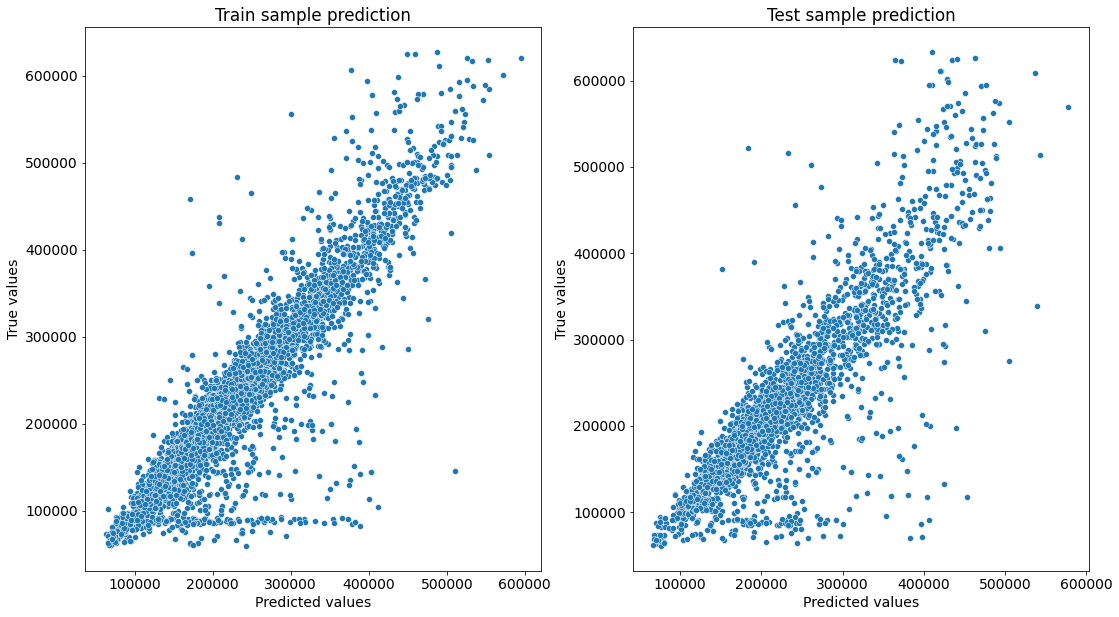

In [70]:
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

In [ ]:
cv_score.mean()

In [ ]:
feature_importance = gb_model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Вариант с RandomForestRegressor, имеет большую склонность к переобучению.
 ##### Train R2: **0.963**
 ##### Test R2:	**0.743**

In [ ]:
# rf_model = RandomForestRegressor(random_state=42, criterion='mse')
# rf_model.fit(X_train, y_train)
#
# y_train_preds = rf_model.predict(X_train)
# y_test_preds = rf_model.predict(X_valid)
#
# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

## 5. Прогнозирование на тестовом датасете
<a name ="Finish"></a>

In [ ]:
submit = pd.read_csv(SUBMIT_FILE_PATH)
submit.head()


In [ ]:
predictions = gb_model.predict(test_df)
predictions


In [ ]:
submit['Price'] = predictions

submit.to_csv(OUTPUT_FILE, index=False)